# Machine Learning Models

## Setup

In [243]:
from tqdm import tqdm
import pandas as pd
import humanize
from datetime import datetime, timedelta
import time
import numpy as np
import seaborn as sns
import ast
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [32]:
df = pd.read_csv("training_data.csv")
df = df.drop(columns=df.columns[0])
df.head()

,runtime,sim_time,surface_moisture,timestep,wind_direction,wind_speed,canopy_moisture,run_max_mem_rss_bytes,area,steps_fire
0,5475,0.050966,0.303030,1.0,0.241645,0.051458,0.833333,0.074582,0.046235,1.0
1,9737,0.128999,0.151515,1.0,0.305913,0.144583,0.750000,0.100625,0.293084,1.0
2,501,0.044546,0.363636,1.0,0.768638,0.051458,0.791667,0.005656,0.011231,1.0
3,4325,0.055708,0.303030,1.0,0.426735,0.083333,0.916667,0.099840,0.131749,1.0
4,9008,0.170005,0.454545,1.0,1.000000,0.144583,0.833333,0.171107,0.061357,1.0


Now let's try to make some models and see what we can do!

In [33]:
y = df["runtime"]

X = df.drop(columns=["runtime"])

In [271]:
TEST_RATIO = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_RATIO,random_state=42)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(len(X_train), len(X_test), len(y_train), len(y_test))

1096 471 1096 471


In [272]:
def print_score(y_true, y_pred):
    print("Mean Squared Error:".ljust(22," "),round(mean_squared_error(y_true, y_pred)))
    print("Mean Absolute Error:".ljust(22," "), round(mean_absolute_error(y_true, y_pred)))

# K Means Clustering

In [273]:
import numpy as np
from sklearn import datasets
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sklearn.metrics as sm
from sklearn.model_selection import train_test_split

In [274]:
# ------ experiment with cluster amount ---------- #
n_clusters = 10
# ------ experiment with cluster amount ---------- #

model = KMeans(n_clusters=n_clusters, n_init=10)
model.fit(X_train,y_train)

KMeans(n_clusters=10, n_init=10)

In [275]:
prediction = model.predict(X_test)

In [276]:
prediction_mapping = (prediction / n_clusters) * y_test.max()
results = pd.DataFrame( {
    "prediction": prediction_mapping,
    "answer":y_test,
    "difference": y_test-prediction_mapping
} )
results

,prediction,answer,difference
0,32332.8,1567,-30765.8
1,5388.8,11449,6060.2
2,32332.8,2287,-30045.8
3,48499.2,592,-47907.2
4,43110.4,14158,-28952.4
...,...,...,...
466,32332.8,23802,-8530.8
467,48499.2,10,-48489.2
468,0.0,10407,10407.0
469,32332.8,1375,-30957.8


In [277]:
print_score(results["answer"], results["prediction"])

Mean Squared Error:    864375735
Mean Absolute Error:   25928


### Now let's try for many values of k

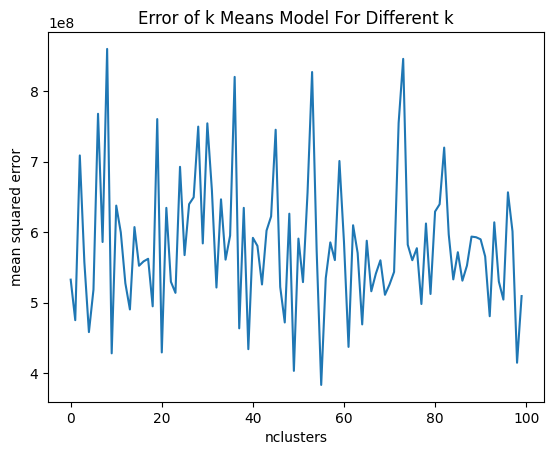

In [278]:
def get_mse(n_clusters):
    global X_test, y_test, X_train, y_train
    n_clusters = 30
    model = KMeans(n_clusters=n_clusters, n_init='auto')
    model.fit(X_train,y_train)
    prediction = model.predict(X_test)
    
    prediction_mapping = (prediction / n_clusters) * y_test.max()
    return mean_squared_error(y_true=y_test, y_pred=prediction_mapping)

get_mse(30)
clusters = list(range(0,100))
MSE = []
for i in clusters:
    MSE.append(round(get_mse(i),2))

plt.title("Error of k Means Model For Different k")
plt.xlabel("nclusters")
plt.ylabel("mean squared error")
plt.plot(clusters,MSE)
plt.show()

so it looks like K means clustering has a long way to go and more clusters has no real effect on the accuracy. Let's try some other methods

# Multi Linear Regression

In [279]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [280]:
model = LinearRegression()
model.fit(X_train,y_train)
model

LinearRegression()

In [281]:
predictions = model.predict(X_test)
predictions.shape

(471,)

In [283]:
print_score(predictions, y_test)

Mean Squared Error:    12633748
Mean Absolute Error:   2371


# Neural Net

In [ ]:
!pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/86/a3/a6ffba31621a402d12b137e656814c7b8de2f796fa976acbe92f4602ebad/tensorflow-2.13.0-cp311-cp311-macosx_10_15_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 2.3 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for flatbuffers>=23.1.21 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.0 MB/s eta 0:00:00
  Obtaining dependency information for h5py>=2.9.0 from https://files.pythonhosted.org/packages/06/3e/935ebbd6cccd0b7965aaaceebabce979e032f15eacfeca12276e790a3e8b/h5py-3.9.0-cp311-cp311-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for libclang>=13.0.0 from https://files.pythonhosted.org/packages/c9/ea/fe2a69cc6cfebf7c7ee8a6357566fc1cbb91632bde5869b669a396accb